In [ ]:
!pip install meteostat

# =======================
# 0. IMPORTS ET DONNÉES
# =======================

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily



# =======================
# 1. TÉLÉCHARGEMENT ET PRÉPARATION DES DONNÉES
# =======================



In [ ]:
start = datetime(2017, 1, 1)
end = datetime(2024, 12, 31)
paris  = Point(48.86069327923436, 2.3476315456936976, 0)
data = Daily(paris, start, end)
data = data.fetch()

In [ ]:
df = data['tavg']
df = pd.DataFrame(df)  # On s'assure que c'est un DataFrame

In [ ]:
# Décomposition saisonnière
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['tavg'], model='additive', period=364)
result.plot()
plt.show()

In [ ]:
# Séparation train / test
train = df[:-366]
test = df[-366:]

In [ ]:
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.legend()
plt.show()

In [ ]:
dataset = df.values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

# =======================
# 2. PRÉPARATION DES SÉQUENCES POUR ENTRAÎNEMENT ET TEST
# =======================

In [ ]:
num_of_days = 10
train_data = scaled_data[0:-366, :]
x_train, y_train = [], []
for i in range(num_of_days, len(train_data)):
    x_train.append(train_data[i-num_of_days:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Jeu de test
test_data = scaled_data[-366:, :]
x_test = []
for i in range(num_of_days, len(test_data)):
    x_test.append(test_data[i-num_of_days:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Pour l'évaluation, on crée le DataFrame de test avec les vraies valeurs
test_results = df[-366 + num_of_days:].copy()
# test_results contiendra à la fois les vraies valeurs et les prédictions

# =======================
# 3. MODÈLE RNN CLASSIQUE
# =======================

In [ ]:
print("\n=== Entraînement RNN ===")
model_RNN = Sequential()
model_RNN.add(SimpleRNN(32, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_RNN.add(Dropout(0.3))
model_RNN.add(SimpleRNN(32, return_sequences=False))
model_RNN.add(Dropout(0.3))
model_RNN.add(Dense(25))
model_RNN.add(Dense(1))
model_RNN.summary()
model_RNN.compile(optimizer='adam', loss='mean_squared_error')
model_RNN.fit(x_train, y_train, batch_size=6, epochs=10)
predictions_RNN = model_RNN.predict(x_test)
predictions_RNN = scaler.inverse_transform(predictions_RNN)
test_results['Predictions_RNN'] = predictions_RNN

# =======================
# 4. MODÈLE LSTM CLASSIQUE
# =======================

In [ ]:
print("\n=== Entraînement LSTM ===")
model_LSTM = Sequential()
model_LSTM.add(LSTM(32, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(LSTM(32, return_sequences=False))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(Dense(25))
model_LSTM.add(Dense(1))
model_LSTM.summary()
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')
model_LSTM.fit(x_train, y_train, batch_size=6, epochs=10)
predictions_LSTM = model_LSTM.predict(x_test)
predictions_LSTM = scaler.inverse_transform(predictions_LSTM)
test_results['Predictions_LSTM'] = predictions_LSTM


=== Entraînement LSTM ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,523 (52.82 KB)

 Trainable params: 13,523 (52.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0261
Epoch 2/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0091
Epoch 3/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0070
Epoch 4/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0066
Epoch 5/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0059
Epoch 6/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0055
Epoch 7/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0047
Epoch 8/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0045
Epoch 9/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0040
Epoch 10/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0039
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


# =======================
# 5. MODÈLE GRU CLASSIQUE
# =======================

In [ ]:
print("\n=== Entraînement GRU ===")
model_GRU = Sequential()
model_GRU.add(GRU(32, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_GRU.add(Dropout(0.3))
model_GRU.add(GRU(32, return_sequences=False))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(25))
model_GRU.add(Dense(1))
model_GRU.summary()
model_GRU.compile(optimizer='adam', loss='mean_squared_error')
model_GRU.fit(x_train, y_train, batch_size=8, epochs=10)
predictions_GRU = model_GRU.predict(x_test)
predictions_GRU = scaler.inverse_transform(predictions_GRU)
test_results['Predictions_GRU'] = predictions_GRU


=== Entraînement GRU ===


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 32)         │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,547 (41.20 KB)

 Trainable params: 10,547 (41.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0329
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0077
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0058
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0047
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0044
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0045
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0040
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0039
Epoch 9/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0038
Epoch 10/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0039
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


# =======================
# 6. SECTION QUANTUM : QLSTM
# =======================

In [ ]:
!pip install pennylane tensorflow

# ------- QLSTM (4 VQC) -------

In [ ]:
print("\n=== Entraînement QLSTM (4 VQC) ===")
import tensorflow as tf
import pennylane as qml
from tensorflow.keras.layers import Layer, RNN

n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="tf")
def forget_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev, interface="tf")
def input_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev, interface="tf")
def output_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev, interface="tf")
def cell_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QLSTMCell4VQC(Layer):
    def __init__(self, units, **kwargs):
        super(QLSTMCell4VQC, self).__init__(**kwargs)
        self.units = units
        self.state_size = [units, units]
        self.forget_qlayer = qml.qnn.KerasLayer(forget_circuit, {"weights": (4, n_qubits)}, output_dim=n_qubits)
        self.input_qlayer = qml.qnn.KerasLayer(input_circuit, {"weights": (4, n_qubits)}, output_dim=n_qubits)
        self.output_qlayer = qml.qnn.KerasLayer(output_circuit, {"weights": (4, n_qubits)}, output_dim=n_qubits)
        self.cell_qlayer = qml.qnn.KerasLayer(cell_circuit, {"weights": (4, n_qubits)}, output_dim=n_qubits)
        self.dense_forget = Dense(n_qubits, activation=None)
        self.dense_input = Dense(n_qubits, activation=None)
        self.dense_output = Dense(n_qubits, activation=None)
        self.dense_cell = Dense(n_qubits, activation=None)
        self.forget_dense = Dense(units, activation='sigmoid')
        self.input_dense = Dense(units, activation='sigmoid')
        self.output_dense = Dense(units, activation='sigmoid')
        self.cell_dense = Dense(units, activation='tanh')

    def call(self, inputs, states):
        h_prev, c_prev = states
        combined = tf.concat([inputs, h_prev], axis=-1)
        # Q layers pour chaque porte
        q_inputs_forget = self.dense_forget(combined)
        forget_qout = self.forget_qlayer(q_inputs_forget)
        forget_gate = self.forget_dense(forget_qout)
        q_inputs_input = self.dense_input(combined)
        input_qout = self.input_qlayer(q_inputs_input)
        input_gate = self.input_dense(input_qout)
        q_inputs_cell = self.dense_cell(combined)
        cell_qout = self.cell_qlayer(q_inputs_cell)
        cell_candidate = self.cell_dense(cell_qout)
        q_inputs_output = self.dense_output(combined)
        output_qout = self.output_qlayer(q_inputs_output)
        output_gate = self.output_dense(output_qout)
        new_c = forget_gate * c_prev + input_gate * cell_candidate
        new_h = output_gate * tf.nn.tanh(new_c)
        return new_h, [new_h, new_c]

qlstm4vqc_cell = QLSTMCell4VQC(32)
model_QLSTM4VQC = Sequential()
model_QLSTM4VQC.add(RNN(qlstm4vqc_cell, return_sequences=False, input_shape=(x_train.shape[1], 1)))
model_QLSTM4VQC.add(Dropout(0.3))
model_QLSTM4VQC.add(Dense(25))
model_QLSTM4VQC.add(Dense(1))
model_QLSTM4VQC.summary()
model_QLSTM4VQC.compile(optimizer='adam', loss='mean_squared_error')
model_QLSTM4VQC.fit(x_train, y_train, batch_size=6, epochs=10)
predictions_QLSTM4VQC = model_QLSTM4VQC.predict(x_test)
predictions_QLSTM4VQC = scaler.inverse_transform(predictions_QLSTM4VQC)
test_results['Predictions_QLSTM4VQC'] = predictions_QLSTM4VQC


=== Entraînement QLSTM (4 VQC) ===


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn (RNN)                       │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 947 (3.70 KB)

 Trainable params: 947 (3.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


425/425 ━━━━━━━━━━━━━━━━━━━━ 296s 461ms/step - loss: 0.0424
Epoch 2/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 204s 465ms/step - loss: 0.0107
Epoch 3/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 204s 471ms/step - loss: 0.0060
Epoch 4/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 197s 464ms/step - loss: 0.0055
Epoch 5/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 199s 468ms/step - loss: 0.0047
Epoch 6/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 199s 462ms/step - loss: 0.0043
Epoch 7/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 204s 466ms/step - loss: 0.0042
Epoch 8/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 204s 470ms/step - loss: 0.0038
Epoch 9/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 200s 466ms/step - loss: 0.0042
Epoch 10/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 202s 465ms/step - loss: 0.0035
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step


# ------- QLSTM (5 VQC) -------

In [ ]:
print("\n=== Entraînement QLSTM (5 VQC) ===")
@qml.qnode(dev, interface="tf")
def h_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QLSTMCell5VQC(Layer):
    def __init__(self, units, **kwargs):
        super(QLSTMCell5VQC, self).__init__(**kwargs)
        self.units = units
        self.state_size = [units, units]
        self.forget_qlayer = qml.qnn.KerasLayer(forget_circuit, {"weights": (4, n_qubits)}, output_dim=n_qubits)
        self.input_qlayer = qml.qnn.KerasLayer(input_circuit, {"weights": (4, n_qubits)}, output_dim=n_qubits)
        self.output_qlayer = qml.qnn.KerasLayer(output_circuit, {"weights": (4, n_qubits)}, output_dim=n_qubits)
        self.cell_qlayer = qml.qnn.KerasLayer(cell_circuit, {"weights": (4, n_qubits)}, output_dim=n_qubits)
        self.h_qlayer = qml.qnn.KerasLayer(h_circuit, {"weights": (4, n_qubits)}, output_dim=n_qubits)
        self.dense_forget = Dense(n_qubits, activation=None)
        self.dense_input = Dense(n_qubits, activation=None)
        self.dense_output = Dense(n_qubits, activation=None)
        self.dense_cell = Dense(n_qubits, activation=None)
        self.dense_h_input = Dense(n_qubits, activation=None)
        self.dense_h = Dense(units, activation=None)
        self.forget_dense = Dense(units, activation='sigmoid')
        self.input_dense = Dense(units, activation='sigmoid')
        self.output_dense = Dense(units, activation='sigmoid')
        self.cell_dense = Dense(units, activation='tanh')

    def call(self, inputs, states):
        h_prev, c_prev = states
        combined = tf.concat([inputs, h_prev], axis=-1)
        q_inputs_forget = self.dense_forget(combined)
        forget_qout = self.forget_qlayer(q_inputs_forget)
        forget_gate = self.forget_dense(forget_qout)
        q_inputs_input = self.dense_input(combined)
        input_qout = self.input_qlayer(q_inputs_input)
        input_gate = self.input_dense(input_qout)
        q_inputs_cell = self.dense_cell(combined)
        cell_qout = self.cell_qlayer(q_inputs_cell)
        cell_candidate = self.cell_dense(cell_qout)
        q_inputs_output = self.dense_output(combined)
        output_qout = self.output_qlayer(q_inputs_output)
        output_gate = self.output_dense(output_qout)
        new_c = forget_gate * c_prev + input_gate * cell_candidate
        h_intermediate = output_gate * tf.nn.tanh(new_c)
        h_inputs = self.dense_h_input(h_intermediate)
        h_qout = self.h_qlayer(h_inputs)
        new_h = self.dense_h(h_qout)
        return new_h, [new_h, new_c]

qlstm5vqc_cell = QLSTMCell5VQC(32)
model_QLSTM5VQC = Sequential()
model_QLSTM5VQC.add(RNN(qlstm5vqc_cell, return_sequences=False, input_shape=(x_train.shape[1], 1)))
model_QLSTM5VQC.add(Dropout(0.3))
model_QLSTM5VQC.add(Dense(25))
model_QLSTM5VQC.add(Dense(1))
model_QLSTM5VQC.summary()
model_QLSTM5VQC.compile(optimizer='adam', loss='mean_squared_error')
model_QLSTM5VQC.fit(x_train, y_train, batch_size=6, epochs=10)
predictions_QLSTM5VQC = model_QLSTM5VQC.predict(x_test)
predictions_QLSTM5VQC = scaler.inverse_transform(predictions_QLSTM5VQC)
test_results['Predictions_QLSTM5VQC'] = predictions_QLSTM5VQC


=== Entraînement QLSTM (5 VQC) ===


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_1 (RNN)                     │ (None, 32)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 971 (3.79 KB)

 Trainable params: 971 (3.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


425/425 ━━━━━━━━━━━━━━━━━━━━ 394s 615ms/step - loss: 0.0437
Epoch 2/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 261s 613ms/step - loss: 0.0073
Epoch 3/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 268s 628ms/step - loss: 0.0059
Epoch 4/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 320s 624ms/step - loss: 0.0045
Epoch 5/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 262s 616ms/step - loss: 0.0042
Epoch 6/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 261s 615ms/step - loss: 0.0037
Epoch 7/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 262s 615ms/step - loss: 0.0038
Epoch 8/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 260s 613ms/step - loss: 0.0035
Epoch 9/10
153/425 ━━━━━━━━━━━━━━━━━━━━ 2:48 618ms/step - loss: 0.0038

# =======================
# 7. COURBES COMPARATIVES DE TOUS LES MODÈLES
# =======================

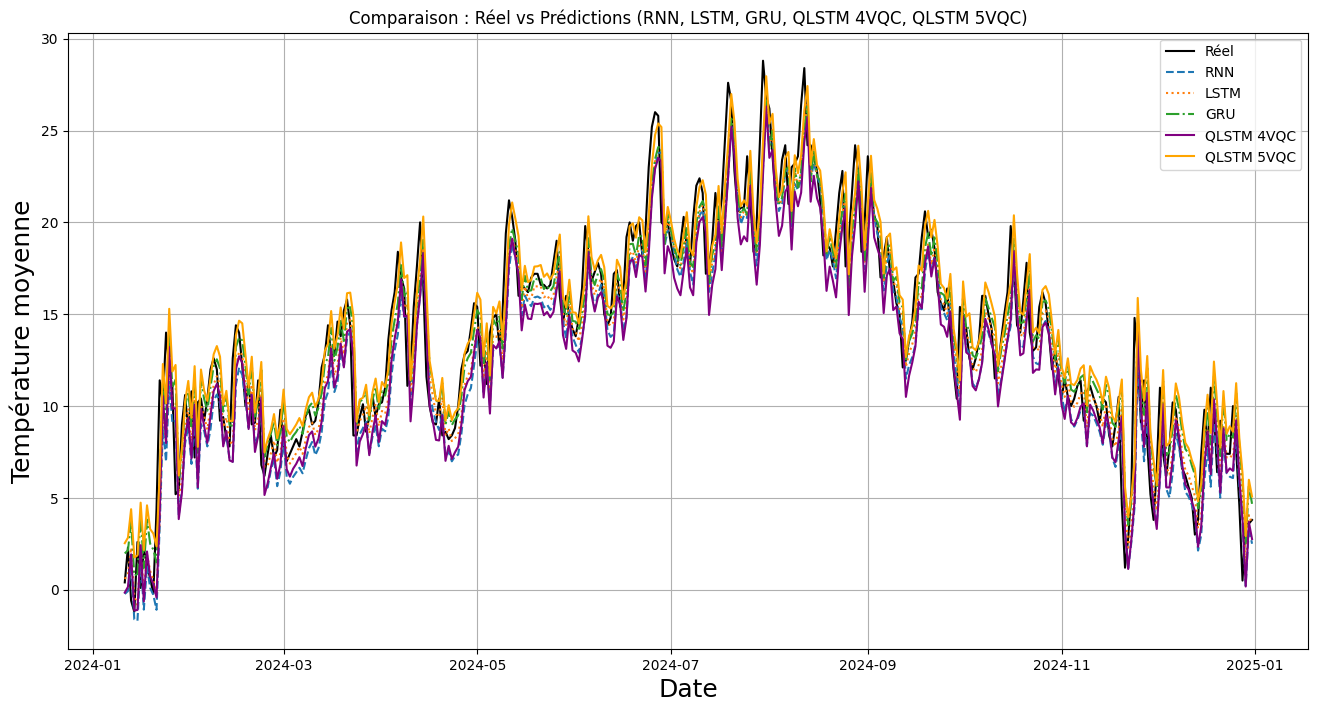

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(16, 8))
plt.title('Comparaison : Réel vs Prédictions (RNN, LSTM, GRU, QLSTM 4VQC, QLSTM 5VQC)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Température moyenne', fontsize=18)
plt.plot(test_results['tavg'], label='Réel', color='black')
plt.plot(test_results['Predictions_RNN'], label='RNN', linestyle='dashed')
plt.plot(test_results['Predictions_LSTM'], label='LSTM', linestyle='dotted')
plt.plot(test_results['Predictions_GRU'], label='GRU', linestyle='dashdot')
plt.plot(test_results['Predictions_QLSTM4VQC'], label='QLSTM 4VQC', linestyle='solid', color='purple')
plt.plot(test_results['Predictions_QLSTM5VQC'], label='QLSTM 5VQC', linestyle='solid', color='orange')
plt.legend()
plt.grid(True)
plt.show()

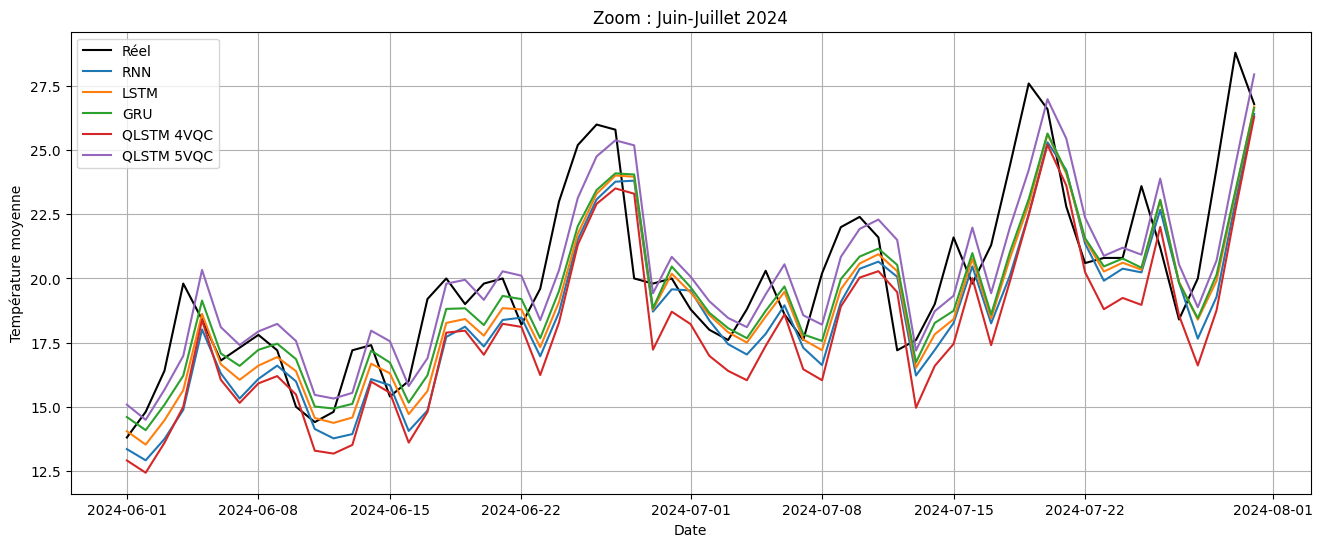

In [ ]:
plt.figure(figsize=(16, 6))
plt.title('Zoom : Juin-Juillet 2024')
plt.xlabel('Date')
plt.ylabel('Température moyenne')
start = '2024-06-01'
end = '2024-07-31'
mask = (test_results.index >= start) & (test_results.index <= end)
plt.plot(test_results.loc[mask, 'tavg'], label='Réel', color='black')
plt.plot(test_results.loc[mask, 'Predictions_RNN'], label='RNN')
plt.plot(test_results.loc[mask, 'Predictions_LSTM'], label='LSTM')
plt.plot(test_results.loc[mask, 'Predictions_GRU'], label='GRU')
plt.plot(test_results.loc[mask, 'Predictions_QLSTM4VQC'], label='QLSTM 4VQC')
plt.plot(test_results.loc[mask, 'Predictions_QLSTM5VQC'], label='QLSTM 5VQC')
plt.legend()
plt.grid(True)
plt.show()

# =======================
# 8. MÉTRIQUES DE TOUS LES MODÈLES
# =======================

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for col, label in [
    ('Predictions_RNN', 'RNN'),
    ('Predictions_LSTM', 'LSTM'),
    ('Predictions_GRU', 'GRU'),
    ('Predictions_QLSTM4VQC', 'QLSTM 4VQC'),
    ('Predictions_QLSTM5VQC', 'QLSTM 5VQC')
]:
    mae = mean_absolute_error(test_results['tavg'], test_results[col])
    rmse = np.sqrt(mean_squared_error(test_results['tavg'], test_results[col]))
    r2 = r2_score(test_results['tavg'], test_results[col])
    print(f"{label} : MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

RNN : MAE=1.9005, RMSE=2.3936, R²=0.8361
LSTM : MAE=1.5988, RMSE=2.0744, R²=0.8769
GRU : MAE=1.5566, RMSE=2.0177, R²=0.8836
QLSTM 4VQC : MAE=1.9702, RMSE=2.4407, R²=0.8296
QLSTM 5VQC : MAE=1.6565, RMSE=2.1380, R²=0.8693
